<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [4]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

**Prepare the dataset**

In [6]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [7]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,11,7,6,3,0,1,...,0,0,0,0,0,0,2,2,0,0


In [8]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [9]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [10]:
# Print dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
67,108,5,0,20,2008-05-17 10:00:04,0
167,108,5,0,20,2008-05-17 10:30:04,0
267,108,5,0,20,2008-05-17 11:00:04,0
367,108,5,0,20,2008-05-17 11:30:04,1
467,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0
114735,168,547,99,2,2008-06-10 07:30:04,0
114835,168,547,99,2,2008-06-10 08:00:04,1
114935,168,547,99,2,2008-06-10 08:30:04,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [11]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [12]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [13]:
# Print traffic_flow dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
67,108,5,0,20,2008-05-17 10:00:04,0,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
167,108,5,0,20,2008-05-17 10:30:04,0,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
267,108,5,0,20,2008-05-17 11:00:04,0,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
367,108,5,0,20,2008-05-17 11:30:04,1,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
467,108,5,0,20,2008-05-17 12:00:04,0,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0,7,1,10,0,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114735,168,547,99,2,2008-06-10 07:30:04,0,7,1,10,30,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3
114835,168,547,99,2,2008-06-10 08:00:04,1,8,1,10,0,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114935,168,547,99,2,2008-06-10 08:30:04,0,8,1,10,30,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3


In [14]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


#### **Make Visualizations**


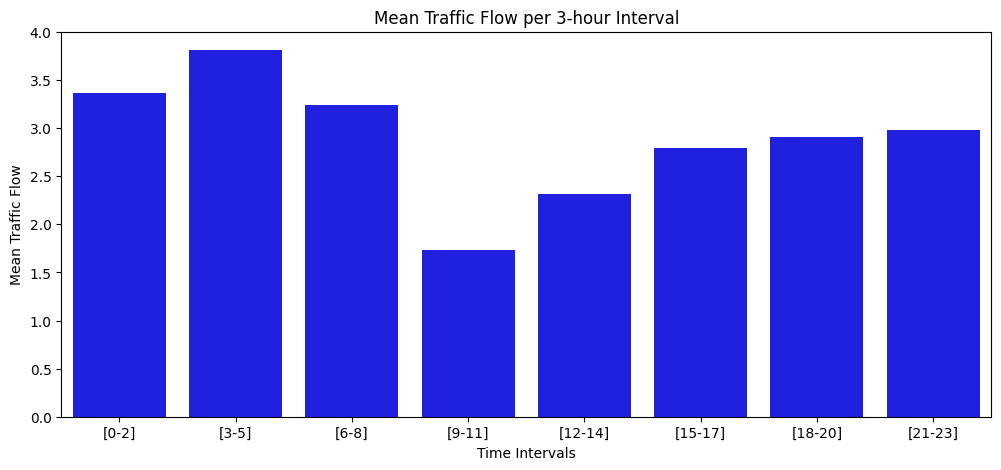

In [15]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', color='blue')
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during noon.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

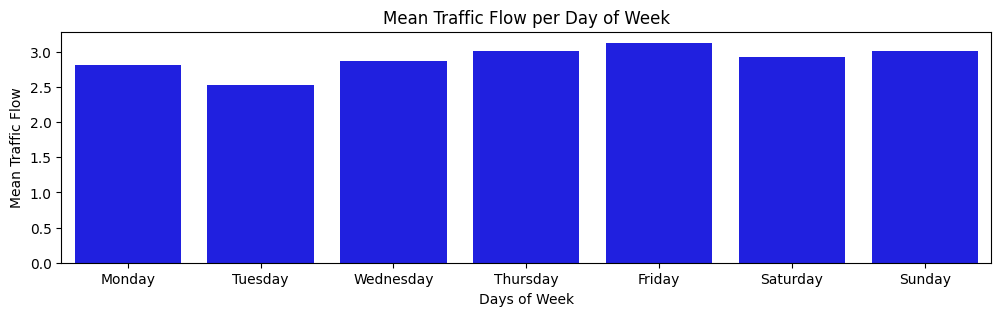

In [16]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow',color='blue')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

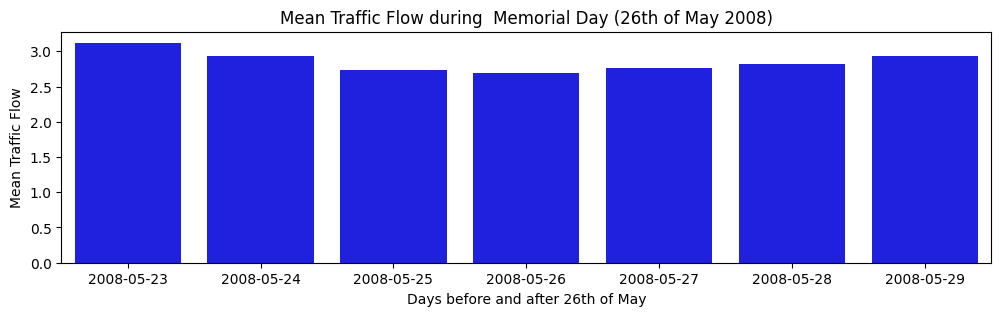

In [17]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow',color='blue')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

<Axes: >

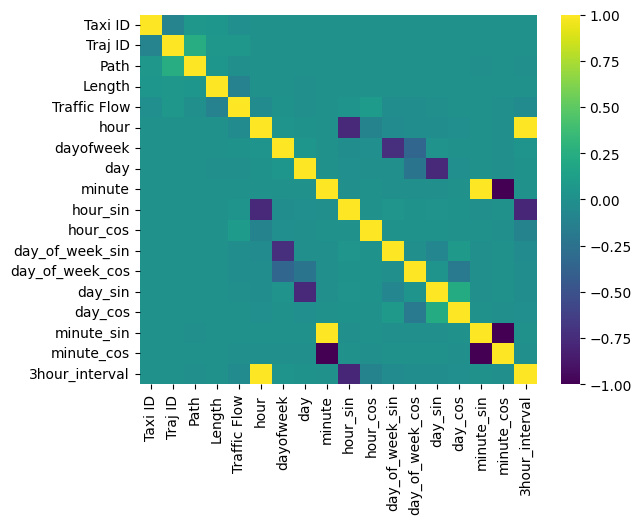

In [18]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [19]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Taxi ID', 'Traj ID', 'Length', 'Traffic Flow', 'hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute', 'minute_cos']

#### **Find the Optimum Sliding Window Length**

In [20]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [21]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [22]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [24]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [25]:
# Define Window Length
optimum_lookback = 2

In [26]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [27]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [28]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [29]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [30]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [31]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.62397	validation_1-rmse:4.43400
[1]	validation_0-rmse:4.30223	validation_1-rmse:4.11935
[2]	validation_0-rmse:4.02191	validation_1-rmse:3.84597
[3]	validation_0-rmse:3.77606	validation_1-rmse:3.60309
[4]	validation_0-rmse:3.56254	validation_1-rmse:3.39454
[5]	validation_0-rmse:3.38025	validation_1-rmse:3.21641
[6]	validation_0-rmse:3.22280	validation_1-rmse:3.06437
[7]	validation_0-rmse:3.08813	validation_1-rmse:2.93001
[8]	validation_0-rmse:2.97318	validation_1-rmse:2.81686
[9]	validation_0-rmse:2.87626	validation_1-rmse:2.72251
[10]	validation_0-rmse:2.79473	validation_1-rmse:2.63979
[11]	validation_0-rmse:2.72445	validation_1-rmse:2.56906
[12]	validation_0-rmse:2.66682	validation_1-rmse:2.51160
[13]	validation_0-rmse:2.61846	validation_1-rmse:2.46434
[14]	validation_0-rmse:2.57811	validation_1-rmse:2.42427
[15]	validation_0-rmse:2.54392	validation_1-rmse:2.38866
[16]	validation_0-rmse:2.51626	validation_1-rmse:2.36132
[17]	validation_0-rmse:2.49399	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [32]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [33]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [34]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.2054436001860727
RMSE score: 2.173402379712098


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [35]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [36]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [37]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [38]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [39]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [40]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 41ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 2/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/50
100/100 [==============================] - 2s 21ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 3s 33ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0013 - val_l

In [41]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

354/354 [==============================] - 5s 13ms/step - loss: 0.0020
Test Loss: 0.0019818588625639677


In [42]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

354/354 [==============================] - 5s 12ms/step


Evaluate the LSTM model

In [43]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2760046258727007
RMSE LSTM score: 2.2704221650522083


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [44]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [45]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,2.173402,1.205444
1,LSTM,2.270422,1.276005


In [46]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [47]:
# Save the LSTM model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 3

In [48]:
# Define Window Length
optimum_lookback = 3

In [49]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [50]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [51]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [52]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [53]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63403	validation_1-rmse:4.44936
[1]	validation_0-rmse:4.31652	validation_1-rmse:4.14251
[2]	validation_0-rmse:4.04039	validation_1-rmse:3.87240
[3]	validation_0-rmse:3.79839	validation_1-rmse:3.63410
[4]	validation_0-rmse:3.58813	validation_1-rmse:3.42469
[5]	validation_0-rmse:3.40550	validation_1-rmse:3.24526
[6]	validation_0-rmse:3.24520	validation_1-rmse:3.08739
[7]	validation_0-rmse:3.10920	validation_1-rmse:2.95411
[8]	validation_0-rmse:2.99195	validation_1-rmse:2.84075
[9]	validation_0-rmse:2.89256	validation_1-rmse:2.74688
[10]	validation_0-rmse:2.80782	validation_1-rmse:2.66351
[11]	validation_0-rmse:2.73620	validation_1-rmse:2.59153
[12]	validation_0-rmse:2.67588	validation_1-rmse:2.53329
[13]	validation_0-rmse:2.62422	validation_1-rmse:2.48150
[14]	validation_0-rmse:2.57924	validation_1-rmse:2.43567
[15]	validation_0-rmse:2.54205	validation_1-rmse:2.40086
[16]	validation_0-rmse:2.51083	validation_1-rmse:2.36886
[17]	validation_0-rmse:2.48524	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [54]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.62925	validation_1-rmse:4.45995
[1]	validation_0-rmse:4.31349	validation_1-rmse:4.14893
[2]	validation_0-rmse:4.03521	validation_1-rmse:3.88075
[3]	validation_0-rmse:3.79369	validation_1-rmse:3.64159
[4]	validation_0-rmse:3.58320	validation_1-rmse:3.43140
[5]	validation_0-rmse:3.40026	validation_1-rmse:3.24821
[6]	validation_0-rmse:3.24180	validation_1-rmse:3.09424
[7]	validation_0-rmse:3.10428	validation_1-rmse:2.95660
[8]	validation_0-rmse:2.98821	validation_1-rmse:2.84314
[9]	validation_0-rmse:2.88876	validation_1-rmse:2.74603
[10]	validation_0-rmse:2.80426	validation_1-rmse:2.66434
[11]	validation_0-rmse:2.73256	validation_1-rmse:2.59096
[12]	validation_0-rmse:2.67177	validation_1-rmse:2.53229
[13]	validation_0-rmse:2.61924	validation_1-rmse:2.48397
[14]	validation_0-rmse:2.57505	validation_1-rmse:2.43902
[15]	validation_0-rmse:2.53819	validation_1-rmse:2.40218
[16]	validation_0-rmse:2.50703	validation_1-rmse:2.37233
[17]	validation_0-rmse:2.48103	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [55]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [56]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1698356371340508
RMSE score: 2.1699030262367534


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [57]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [58]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [59]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [60]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [61]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [62]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 6s 17ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/50
100/100 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 3s 34ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/50
100/100 [==============================] - 5s 47ms/step - loss: 0.0013 - val_loss

In [63]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

350/350 [==============================] - 9s 27ms/step - loss: 0.0020
Test Loss: 0.0019682778511196375


In [64]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

350/350 [==============================] - 5s 13ms/step


Evaluate the LSTM model

In [65]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.228174548926098
RMSE LSTM score: 2.2626292099279786


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [66]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [67]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,2.169903,1.169836
1,LSTM,2.262629,1.228175


In [68]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [69]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 4

In [70]:
optimum_lookback = 4

In [71]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [72]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [73]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [74]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [75]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63529	validation_1-rmse:4.44428
[1]	validation_0-rmse:4.32004	validation_1-rmse:4.13775
[2]	validation_0-rmse:4.04639	validation_1-rmse:3.87419
[3]	validation_0-rmse:3.80519	validation_1-rmse:3.64196
[4]	validation_0-rmse:3.59569	validation_1-rmse:3.43512
[5]	validation_0-rmse:3.41365	validation_1-rmse:3.25625
[6]	validation_0-rmse:3.25712	validation_1-rmse:3.10303
[7]	validation_0-rmse:3.12016	validation_1-rmse:2.96865
[8]	validation_0-rmse:3.00280	validation_1-rmse:2.85432
[9]	validation_0-rmse:2.90189	validation_1-rmse:2.75483
[10]	validation_0-rmse:2.81771	validation_1-rmse:2.67036
[11]	validation_0-rmse:2.74450	validation_1-rmse:2.59784
[12]	validation_0-rmse:2.68175	validation_1-rmse:2.53598
[13]	validation_0-rmse:2.62939	validation_1-rmse:2.48450
[14]	validation_0-rmse:2.58493	validation_1-rmse:2.44189
[15]	validation_0-rmse:2.54766	validation_1-rmse:2.40396
[16]	validation_0-rmse:2.51461	validation_1-rmse:2.36964
[17]	validation_0-rmse:2.48751	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [76]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63086	validation_1-rmse:4.45870
[1]	validation_0-rmse:4.31565	validation_1-rmse:4.15355
[2]	validation_0-rmse:4.03983	validation_1-rmse:3.88751
[3]	validation_0-rmse:3.79927	validation_1-rmse:3.64790
[4]	validation_0-rmse:3.58828	validation_1-rmse:3.44064
[5]	validation_0-rmse:3.40600	validation_1-rmse:3.25803
[6]	validation_0-rmse:3.24806	validation_1-rmse:3.10255
[7]	validation_0-rmse:3.11230	validation_1-rmse:2.96978
[8]	validation_0-rmse:2.99480	validation_1-rmse:2.85193
[9]	validation_0-rmse:2.89424	validation_1-rmse:2.75318
[10]	validation_0-rmse:2.80905	validation_1-rmse:2.66755
[11]	validation_0-rmse:2.73698	validation_1-rmse:2.59535
[12]	validation_0-rmse:2.67559	validation_1-rmse:2.53467
[13]	validation_0-rmse:2.62287	validation_1-rmse:2.48260
[14]	validation_0-rmse:2.57969	validation_1-rmse:2.43968
[15]	validation_0-rmse:2.54206	validation_1-rmse:2.40086
[16]	validation_0-rmse:2.50985	validation_1-rmse:2.36911
[17]	validation_0-rmse:2.48033	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [77]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [78]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1521729819796693
RMSE score: 2.152961982397872


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [79]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [80]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [81]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [82]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [83]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [84]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 11s 65ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/50
100/100 [==============================] - 6s 56ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/50
100/100 [==============================] - 3s 26ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0013 - val_lo

In [85]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

347/347 [==============================] - 5s 16ms/step - loss: 0.0019
Test Loss: 0.001900296425446868


In [86]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

347/347 [==============================] - 5s 14ms/step


Evaluate the LSTM model

In [87]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2414795575217084
RMSE LSTM score: 2.2232119273268007


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [88]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [89]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,2.152962,1.152173
1,LSTM,2.223212,1.241480


In [90]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [91]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length equals to 5

In [92]:
optimum_lookback = 5

In [93]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [94]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [95]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [96]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [97]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63615	validation_1-rmse:4.44300
[1]	validation_0-rmse:4.32056	validation_1-rmse:4.13834
[2]	validation_0-rmse:4.04712	validation_1-rmse:3.87469
[3]	validation_0-rmse:3.80627	validation_1-rmse:3.64204
[4]	validation_0-rmse:3.59710	validation_1-rmse:3.43549
[5]	validation_0-rmse:3.41500	validation_1-rmse:3.25822
[6]	validation_0-rmse:3.25653	validation_1-rmse:3.10365
[7]	validation_0-rmse:3.12067	validation_1-rmse:2.96957
[8]	validation_0-rmse:3.00344	validation_1-rmse:2.85391
[9]	validation_0-rmse:2.90371	validation_1-rmse:2.75614
[10]	validation_0-rmse:2.81886	validation_1-rmse:2.66968
[11]	validation_0-rmse:2.74455	validation_1-rmse:2.59735
[12]	validation_0-rmse:2.68341	validation_1-rmse:2.53613
[13]	validation_0-rmse:2.62923	validation_1-rmse:2.48177
[14]	validation_0-rmse:2.58426	validation_1-rmse:2.43612
[15]	validation_0-rmse:2.54718	validation_1-rmse:2.39884
[16]	validation_0-rmse:2.51381	validation_1-rmse:2.36581
[17]	validation_0-rmse:2.48614	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [98]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63137	validation_1-rmse:4.45565
[1]	validation_0-rmse:4.31624	validation_1-rmse:4.15229
[2]	validation_0-rmse:4.04041	validation_1-rmse:3.88594
[3]	validation_0-rmse:3.80030	validation_1-rmse:3.64769
[4]	validation_0-rmse:3.58860	validation_1-rmse:3.44092
[5]	validation_0-rmse:3.40654	validation_1-rmse:3.25897
[6]	validation_0-rmse:3.24846	validation_1-rmse:3.10510
[7]	validation_0-rmse:3.11170	validation_1-rmse:2.97026
[8]	validation_0-rmse:2.99505	validation_1-rmse:2.85269
[9]	validation_0-rmse:2.89505	validation_1-rmse:2.75081
[10]	validation_0-rmse:2.80850	validation_1-rmse:2.66456
[11]	validation_0-rmse:2.73666	validation_1-rmse:2.59051
[12]	validation_0-rmse:2.67560	validation_1-rmse:2.53055
[13]	validation_0-rmse:2.62379	validation_1-rmse:2.47885
[14]	validation_0-rmse:2.57955	validation_1-rmse:2.43527
[15]	validation_0-rmse:2.54165	validation_1-rmse:2.39803
[16]	validation_0-rmse:2.51060	validation_1-rmse:2.36642
[17]	validation_0-rmse:2.48143	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [99]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [100]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1433695860403612
RMSE score: 2.139310308953228


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [101]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [102]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [103]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [104]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [105]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [106]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 11s 61ms/step - loss: 0.0051 - val_loss: 0.0076
Epoch 2/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/50
100/100 [==============================] - 5s 53ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 5/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 7/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0013 - val_loss: 0.0020


In [107]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

344/344 [==============================] - 5s 16ms/step - loss: 0.0019
Test Loss: 0.0019313169177621603


In [108]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

344/344 [==============================] - 3s 7ms/step


Evaluate the LSTM model

In [109]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2456366031467914
RMSE LSTM score: 2.241284290174428


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [110]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [111]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,2.139310,1.143370
1,LSTM,2.241284,1.245637


In [112]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [113]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equal to 6

In [114]:
optimum_lookback = 6

In [115]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [116]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [117]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [118]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [119]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63531	validation_1-rmse:4.42579
[1]	validation_0-rmse:4.32024	validation_1-rmse:4.12145
[2]	validation_0-rmse:4.04680	validation_1-rmse:3.85818
[3]	validation_0-rmse:3.80580	validation_1-rmse:3.62815
[4]	validation_0-rmse:3.59670	validation_1-rmse:3.42248
[5]	validation_0-rmse:3.41466	validation_1-rmse:3.24498
[6]	validation_0-rmse:3.25637	validation_1-rmse:3.09069
[7]	validation_0-rmse:3.12114	validation_1-rmse:2.95769
[8]	validation_0-rmse:3.00377	validation_1-rmse:2.84172
[9]	validation_0-rmse:2.90396	validation_1-rmse:2.74334
[10]	validation_0-rmse:2.81743	validation_1-rmse:2.65679
[11]	validation_0-rmse:2.74470	validation_1-rmse:2.58425
[12]	validation_0-rmse:2.68273	validation_1-rmse:2.52397
[13]	validation_0-rmse:2.62876	validation_1-rmse:2.46957
[14]	validation_0-rmse:2.58434	validation_1-rmse:2.42442
[15]	validation_0-rmse:2.54698	validation_1-rmse:2.38684
[16]	validation_0-rmse:2.51367	validation_1-rmse:2.35244
[17]	validation_0-rmse:2.48736	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [120]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63109	validation_1-rmse:4.44007
[1]	validation_0-rmse:4.31620	validation_1-rmse:4.13706
[2]	validation_0-rmse:4.04087	validation_1-rmse:3.87137
[3]	validation_0-rmse:3.80099	validation_1-rmse:3.63564
[4]	validation_0-rmse:3.59035	validation_1-rmse:3.43040
[5]	validation_0-rmse:3.40832	validation_1-rmse:3.24823
[6]	validation_0-rmse:3.25031	validation_1-rmse:3.09290
[7]	validation_0-rmse:3.11449	validation_1-rmse:2.95921
[8]	validation_0-rmse:2.99672	validation_1-rmse:2.84203
[9]	validation_0-rmse:2.89648	validation_1-rmse:2.74292
[10]	validation_0-rmse:2.81165	validation_1-rmse:2.65795
[11]	validation_0-rmse:2.73870	validation_1-rmse:2.58500
[12]	validation_0-rmse:2.67624	validation_1-rmse:2.52442
[13]	validation_0-rmse:2.62371	validation_1-rmse:2.47271
[14]	validation_0-rmse:2.57877	validation_1-rmse:2.42695
[15]	validation_0-rmse:2.54191	validation_1-rmse:2.38786
[16]	validation_0-rmse:2.51002	validation_1-rmse:2.35597
[17]	validation_0-rmse:2.48308	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [121]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [122]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1419149028644426
RMSE score: 2.136560638808865


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [123]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [124]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [125]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [126]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [127]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [128]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 22ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 2/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
100/100 [==============================] - 8s 81ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 7/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/50
100/100 [==============================] - 6s 63ms/step - loss: 0.0012 - val_lo

In [129]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

341/341 [==============================] - 5s 16ms/step - loss: 0.0019
Test Loss: 0.001881083007901907


In [130]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

341/341 [==============================] - 7s 18ms/step


Evaluate the LSTM model

In [131]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.1998416563048275
RMSE LSTM score: 2.211944276980721


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [132]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [133]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,2.136561,1.141915
1,LSTM,2.211944,1.199842


In [134]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [135]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")